In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### 패키지 설치 & 라이브러리 import

In [47]:
!pip install optuna
!pip install torchinfo

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [49]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [50]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [51]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [52]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [53]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(X, y):

    #Train, Test 분류
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Train, Validation 분류
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    # # 데이터 크기 출력
    # print("Train set:", X_train.shape, y_train.shape)
    # print("Validation set:", X_val.shape, y_val.shape)
    # print("Test set:", X_test.shape, y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [54]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [55]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # 시퀀스 생성
  train_x, train_y = create_sequences(tri[['lat', 'lon', 'alt']], sequence_length)

  # train, validation, test 분리
  X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(train_x, train_y)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [56]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [57]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [58]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        if d_model % 2 != 0:
            raise ValueError("d_model must be even, got odd number {}".format(d_model))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # 배치 차원 추가
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.size(1) = 시퀀스 길이
        x = x + self.pe[:, :x.size(1), :]
        return x

In [59]:
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # input_dim에서 d_model로 변환
        self.positional_encoding = PositionalEncoding(d_model)  # 포지셔널 인코딩 추가
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(d_model, input_dim)  # d_model에서 input_dim으로 변환

    def forward(self, src):
        src = self.embedding(src)  # 입력 차원 -> d_model로 변환
        src = self.positional_encoding(src)
        src = src.permute(1, 0, 2)  # (batch_size, seq_length, d_model) -> (seq_length, batch_size, d_model)
        output = self.transformer_encoder(src)  # Transformer Encoder 통과
        output = self.fc_out(output)  # (seq_length, batch_size, d_model) -> (seq_length, batch_size, input_dim)

        # 마지막 시점의 출력만 반환
        return output[-1, :, :]  # shape: (batch_size, input_dim)

## 하이퍼파라미터 탐색

### 1. Optuna의 objective 함수 선언

- 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
- objective 함수 선언

In [72]:
import optuna

def objective(trial, tri, sequence_length):
    # 탐색할 하이퍼파라미터 값 결정
    nhead = trial.suggest_int('nhead', 2, 8)
    d_model = trial.suggest_int('d_model', nhead * 8, nhead * 64, step=nhead) # d_model을 nhead의 배수로 설정하여 짝수 보장
    if d_model % 2 != 0:     # d_model이 홀수인 경우 짝수로 조정
        d_model += 1

    if d_model % nhead != 0: # d_model이 nhead의 배수가 아닌 경우 강제로 배수로 조정
        d_model += nhead - (d_model % nhead)

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    num_epochs = 200
    intput_size = 3

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 데이터셋 로더
    train_loader, val_loader, _ = create_dataloaders(tri, batch_size, sequence_length)

    # 모델 정의: Transformer Model
    model = TransformerModel(
        input_dim=intput_size,
        seq_length=sequence_length,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward
    ).to(device)  # GPU 사용

    # 손실 함수
    criterion = nn.MSELoss()

    # 최적화 함수
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_val_loss = 0.0  # 모든 epoch에서의 validation loss의 합
    val_loss_count = 0    # 평균을 계산하기 위한 epoch 수

    # 모델 학습
    for epoch in range(num_epochs):
        # Train set으로 학습
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터도 GPU로 이동
            optimizer.zero_grad()
            output = model(batch_X)  # 출력 형태: (batch_size, input_dim)

            # Loss 계산
            loss = criterion(output, batch_y)  # y의 형태: (batch_size, input_dim)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation set에서 성능 측정
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X)

                # Loss 계산
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        # 배치 수로 나눠서 평균 validation 손실 계산
        val_loss_avg = val_loss / len(val_loader)

        # Optuna에 중간 값 보고
        trial.report(val_loss_avg, epoch)

        # 총 validation 손실 계산
        total_val_loss += val_loss_avg
        val_loss_count += 1

        # Pruning 조건 확인
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            print(f"Validation Loss at prune: {val_loss_avg:.4f}")  # Prune 시점에서 validation loss 출력

            raise optuna.TrialPruned()

    # 모든 epoch에서의 validation Loss avg 반환
    return total_val_loss / val_loss_count

### 3. 탐색 범위 외의 하이퍼파라미터 선언

In [61]:
sequence_length = 10
early_stopping_rounds = 10
n_trials = 30

### 4. 하이퍼 파라미터 탐색

In [62]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, tri, sequence_length), n_trials=n_trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-01 12:17:04,996] A new study created in memory with name: no-name-7d5b0de6-44b1-464b-b336-8faed2ae9fe3
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:17:43,520] Trial 0 finished with value: 8.540038380624543e-05 and parameters: {'nhead': 6, 'd_model': 162, 'num_encoder_layers': 1, 'dim_feedforward': 434, 'learning_rate': 0.0007918835265647668, 'batch_size': 113}. Best is trial 0 with value: 8.540038380624543e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use

Trial 5 pruned at epoch 0
Validation Loss at prune: 0.0323


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:49,333] Trial 6 pruned. 


Trial 6 pruned at epoch 0
Validation Loss at prune: 0.0548


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:49,804] Trial 7 pruned. 


Trial 7 pruned at epoch 0
Validation Loss at prune: 0.0153


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:51,626] Trial 8 pruned. 


Trial 8 pruned at epoch 4
Validation Loss at prune: 0.0007


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:52,227] Trial 9 pruned. 


Trial 9 pruned at epoch 0
Validation Loss at prune: 0.0182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:53,353] Trial 10 pruned. 


Trial 10 pruned at epoch 0
Validation Loss at prune: 0.0164


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:55,046] Trial 11 pruned. 


Trial 11 pruned at epoch 5
Validation Loss at prune: 0.0003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:56,215] Trial 12 pruned. 


Trial 12 pruned at epoch 1
Validation Loss at prune: 0.0017


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:56,900] Trial 13 pruned. 


Trial 13 pruned at epoch 0
Validation Loss at prune: 0.0122


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:57,383] Trial 14 pruned. 


Trial 14 pruned at epoch 0
Validation Loss at prune: 0.0535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:23:58,171] Trial 15 pruned. 


Trial 15 pruned at epoch 0
Validation Loss at prune: 0.0228


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:24:30,342] Trial 16 finished with value: 7.856033987923181e-05 and parameters: {'nhead': 7, 'd_model': 224, 'num_encoder_layers': 1, 'dim_feedforward': 138, 'learning_rate': 0.00022565433133084898, 'batch_size': 111}. Best is trial 16 with value: 7.856033987923181e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nes

Trial 17 pruned at epoch 0
Validation Loss at prune: 0.0996


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:11,327] Trial 18 finished with value: 9.908528439109431e-05 and parameters: {'nhead': 8, 'd_model': 512, 'num_encoder_layers': 1, 'dim_feedforward': 203, 'learning_rate': 3.96319110529074e-05, 'batch_size': 111}. Best is trial 16 with value: 7.856033987923181e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 19 pruned at epoch 0
Validation Loss at prune: 0.0079


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:12,347] Trial 20 pruned. 


Trial 20 pruned at epoch 0
Validation Loss at prune: 0.0089


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:12,837] Trial 21 pruned. 


Trial 21 pruned at epoch 0
Validation Loss at prune: 0.0144


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:13,312] Trial 22 pruned. 


Trial 22 pruned at epoch 0
Validation Loss at prune: 0.0270


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:13,924] Trial 23 pruned. 


Trial 23 pruned at epoch 1
Validation Loss at prune: 0.0013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:14,626] Trial 24 pruned. 


Trial 24 pruned at epoch 0
Validation Loss at prune: 0.0567


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:15,364] Trial 25 pruned. 


Trial 25 pruned at epoch 0
Validation Loss at prune: 0.0883


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:16,093] Trial 26 pruned. 


Trial 26 pruned at epoch 0
Validation Loss at prune: 0.0149


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:25:16,865] Trial 27 pruned. 


Trial 27 pruned at epoch 0
Validation Loss at prune: 0.0540


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-01 12:26:06,042] Trial 28 finished with value: 7.224210826025766e-05 and parameters: {'nhead': 7, 'd_model': 294, 'num_encoder_layers': 1, 'dim_feedforward': 134, 'learning_rate': 0.00020244245082635354, 'batch_size': 65}. Best is trial 28 with value: 7.224210826025766e-05.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nest

Trial 29 pruned at epoch 2
Validation Loss at prune: 0.0014
Best hyperparameters:  {'nhead': 7, 'd_model': 294, 'num_encoder_layers': 1, 'dim_feedforward': 134, 'learning_rate': 0.00020244245082635354, 'batch_size': 65}


### 5. 하이퍼파라미터 저장

In [73]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


## 학습

### 1. 하이퍼파라미터 불러오기

In [64]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 7, 'd_model': 294, 'num_encoder_layers': 1, 'dim_feedforward': 134, 'learning_rate': 0.00020244245082635354, 'batch_size': 65}


### 2. 최적의 파라미터로 모델 학습

In [82]:
sequence_length = 10
num_epochs = 100

In [83]:
# 최적의 모델 학습
best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    seq_length=10,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [84]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 입력 데이터 차원 조정
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    model_save_path = f"best_model_epoch_{epoch+1}.pth"
    torch.save(best_model.state_dict(), model_save_path)
    print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{50} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/100], Train Loss: 2.8438, Val Loss: 0.0356
Model saved: best_model_epoch_1.pth
Epoch 1/50 completed in 0.24 seconds.
Epoch [2/100], Train Loss: 0.3391, Val Loss: 0.0119
Model saved: best_model_epoch_2.pth
Epoch 2/50 completed in 0.21 seconds.
Epoch [3/100], Train Loss: 0.2415, Val Loss: 0.0076
Model saved: best_model_epoch_3.pth
Epoch 3/50 completed in 0.22 seconds.
Epoch [4/100], Train Loss: 0.1907, Val Loss: 0.0035
Model saved: best_model_epoch_4.pth
Epoch 4/50 completed in 0.22 seconds.
Epoch [5/100], Train Loss: 0.1354, Val Loss: 0.0072
Model saved: best_model_epoch_5.pth
Epoch 5/50 completed in 0.22 seconds.
Epoch [6/100], Train Loss: 0.1073, Val Loss: 0.0043
Model saved: best_model_epoch_6.pth
Epoch 6/50 completed in 0.22 seconds.
Epoch [7/100], Train Loss: 0.0938, Val Loss: 0.0056
Model saved: best_model_epoch_7.pth
Epoch 7/50 completed in 0.23 seconds.
Epoch [8/100], Train Loss: 0.0802, Val Loss: 0.0067
Model saved: best_model_epoch_8.pth
Epoch 8/50 completed in 0.29 s

### 3. 모델 요약 내용 출력

In [85]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 294]              1,176
├─PositionalEncoding: 1-2                     [1, 10, 294]              --
├─TransformerEncoder: 1-3                     [10, 1, 294]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [10, 1, 294]              427,316
├─Linear: 1-4                                 [10, 1, 3]                885
Total params: 429,377
Trainable params: 429,377
Non-trainable params: 0
Total mult-adds (M): 0.81
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.33
Estimated Total Size (MB): 0.44

## 테스트

### 1. 테스트 결과 생성

In [86]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 6.872568337712437e-05
Mean Absolute Error (MAE): 0.006725048180669546


### 2. 결과 시각화

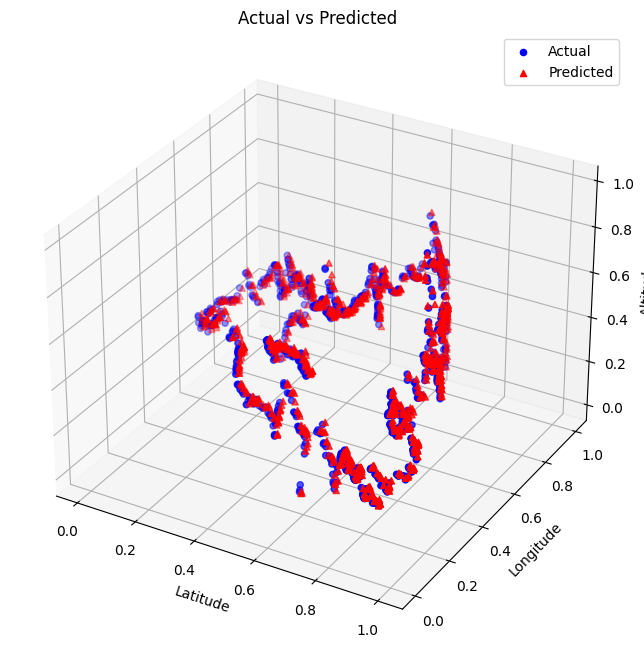

In [87]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

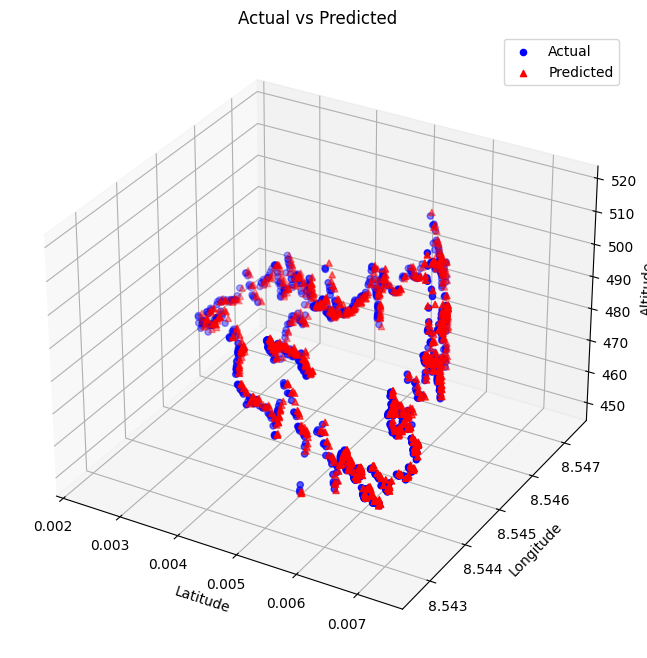

In [88]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)